ott-jax commit hash: 72885ac75491d98e55b4f039c583134d3c2ba7b7

In [1]:
from typing import Iterator, Literal, Optional, Union
import functools
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import optax
import jax
import ott
from genot.nets.nets import MLP_vector_field, MLP_marginal
from ott.neural.flows.models import VelocityField as OttVelocityField
from ott.solvers.linear import sinkhorn, acceleration
from ott.geometry import costs
from ott.neural.methods.flows.otfm import OTFlowMatching
from ott.neural.methods.flows.dynamics import (
    BaseFlow,
#    BrownianNoiseFlow,
    ConstantNoiseFlow,
)
from ott.solvers.utils import uniform_sampler
from genot.data.data import MixtureNormalSampler
from genot.models.model import GENOT

'''
from ott.geometry import costs
from ott.neural.flows.genot import GENOT
from ott.neural.flows.otfm import OTFlowMatching
from ott.neural.flows.models import VelocityField
from ott.neural.flows.samplers import sample_uniformly
from ott.neural.models.models import RescalingMLP
from ott.solvers.linear import sinkhorn
from ott.solvers.quadratic import gromov_wasserstein
from ott.neural.data.dataloaders import ConditionalDataLoader, OTDataLoader
from ott.neural.flows.flows import (
    BaseFlow,
    BrownianNoiseFlow,
    ConstantNoiseFlow,
)
'''

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-07 10:59:04.232664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730973545.557438 1058559 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730973546.287489 1058559 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'\nfrom ott.geometry import costs\nfrom ott.neural.flows.genot import GENOT\nfrom ott.neural.flows.otfm import OTFlowMatching\nfrom ott.neural.flows.models import VelocityField\nfrom ott.neural.flows.samplers import sample_uniformly\nfrom ott.neural.models.models import RescalingMLP\nfrom ott.solvers.linear import sinkhorn\nfrom ott.solvers.quadratic import gromov_wasserstein\nfrom ott.neural.data.dataloaders import ConditionalDataLoader, OTDataLoader\nfrom ott.neural.flows.flows import (\n    BaseFlow,\n    BrownianNoiseFlow,\n    ConstantNoiseFlow,\n)\n'

In [2]:
@jax.tree_util.register_pytree_node_class
class CoulombCost(costs.CostFn):
    def pairwise(self, x: jnp.ndarray, y: jnp.ndarray) -> float:
        return 1.0/(jnp.linalg.norm((x-y), ord=2, axis=-1))**2

In [3]:
source_1 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([-2, -2]), 0.05*np.eye(2), (5000,))
source_2 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([-2, 2]), 0.05*np.eye(2), (5000,))

target_1 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([2, -2]), 0.05*np.eye(2), (5000,))
target_2 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([2, 2]), 0.05*np.eye(2), (5000,))

In [4]:
source = jax.random.permutation(jax.random.PRNGKey(0), jnp.concatenate((source_1, source_2), axis=0))
target = jax.random.permutation(jax.random.PRNGKey(0), jnp.concatenate((target_1, target_2), axis=0))

In [5]:
#dl = OTDataLoader(1024, source_lin=source, target_lin=target)

In [6]:
source_test = source[:50] #50

In [7]:
epsilon=1e-3
iterations=3_000
source_dim = 2
target_dim = 2
condition_dim = 0
latent_embed_dim = 256
n_frequencies = 1024

# GENOT

In [8]:
neural_vf = MLP_vector_field(output_dim=target_dim,
                             condition_embed_dim = source_dim + condition_dim,
                             latent_embed_dim=latent_embed_dim,
                             n_frequencies=n_frequencies)

ot_solver = sinkhorn.Sinkhorn()
cost_fn = CoulombCost()
#time_sampler = sample_uniformly
time_sampler = uniform_sampler
optimizer = optax.adam(learning_rate=1e-4)
genot = GENOT(
    neural_vf, #
    input_dim=source_dim, #
    output_dim=target_dim, #
#    cond_dim=condition_dim,
    iterations=iterations, #
#    valid_freq=iterations,
    ot_solver=ot_solver, #
    epsilon=epsilon, #
    cost_fn=cost_fn, #
    scale_cost=1.0, #
    optimizer=optimizer, #
#    time_sampler=time_sampler,
#    k_samples_per_x=1,
    solver_latent_to_data=None, #
)
genot(source, target, 1024, 1024)

I0000 00:00:1730973672.108617 1058559 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6704 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:4d:00.0, compute capability: 7.0
100%|██████████| 3000/3000 [02:25<00:00, 20.59it/s]


In [9]:
result_genot = genot.transport(
    source_test
)

(-3.0, 3.0)

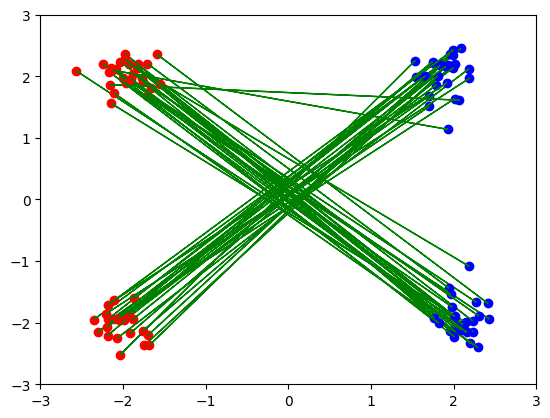

In [10]:
for source_point, target_point in zip(source_test, result_genot[0][0]):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)

plt.xlim((-3, 3))
plt.ylim((-3, 3))

In [12]:
ott.__version__

'0.4.7'

# OTFM (deterministic)

In [12]:
neural_vf_fm = MLP_vector_field(output_dim=target_dim,
                             condition_embed_dim=condition_dim,
                             latent_embed_dim=latent_embed_dim
)

time_sampler = uniform_sampler

fm = OTFlowMatching(
        neural_vf_fm,
        input_dim=source_dim,
        cond_dim=condition_dim,
        iterations=iterations,
        valid_freq=iterations,
        ot_solver=ot_solver,
        flow=ConstantNoiseFlow(0),
        time_sampler=time_sampler,
        optimizer=optimizer,
        epsilon=epsilon,
        cost_fn=CoulombCost(),
        scale_cost=1.0,
    )
fm(dl, dl)

AttributeError: "MLP_vector_field" object has no attribute "output_dims". If "output_dims" is defined in '.setup()', remember these fields are only accessible from inside 'init' or 'apply'.

In [ ]:
neural_vf_fm = VelocityField(
    output_dim=target_dim,
    condition_dim=condition_dim,
    latent_embed_dim=latent_embed_dim,
)

fm = OTFlowMatching(
        neural_vf_fm,
        input_dim=source_dim,
        cond_dim=condition_dim,
        iterations=iterations,
        valid_freq=iterations,
        ot_solver=ot_solver,
        flow=ConstantNoiseFlow(0),
        time_sampler=time_sampler,
        optimizer=optimizer,
        epsilon=epsilon,
        cost_fn=CoulombCost(),
        scale_cost=1.0,
    )
fm(dl, dl)

In [ ]:
result_fm = fm.transport(
    source_test, condition=None, forward=True
)

In [ ]:
np.save("result_ot_cfm_deterministic", result_fm)

In [ ]:
for source_point, target_point in zip(source_test, result_fm):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)

plt.xlim((-3, 3))
plt.ylim((-3, 3))

# OTFM Brownian bridge

In [ ]:
neural_vf_fm = VelocityField(
    output_dim=target_dim,
    condition_dim=condition_dim,
    latent_embed_dim=latent_embed_dim,
)

sigma = np.sqrt(epsilon/2.0)

fm = OTFlowMatching(
        neural_vf_fm,
        input_dim=source_dim,
        cond_dim=condition_dim,
        iterations=iterations,
        valid_freq=iterations,
        ot_solver=ot_solver,
        flow=BrownianNoiseFlow(sigma),
        time_sampler=time_sampler,
        optimizer=optimizer,
        epsilon=epsilon,
        cost_fn=CoulombCost(),
        scale_cost=1.0,
    )
fm(dl, dl)

In [ ]:
result_fm = fm.transport(
    source_test, condition=None, forward=True
)

In [ ]:
np.save("result_ot_cfm_entropic", result_fm)

In [ ]:
for source_point, target_point in zip(source_test, result_fm):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)
plt.xlim((-3, 3))
plt.ylim((-3, 3))

# Data

In [ ]:
plt.scatter(
    source[:500, 0], 
    source[:500, 1],
    color="blue",
)
plt.scatter(
    target[:500, 0], 
    target[:500, 1],
    color="red",
)

plt.xlim((-3, 3))
plt.ylim((-3, 3))

In [ ]:
np.save("source_test", source_test)
np.save("source", source)
np.save("target", target)